In [52]:
import pandas as pd
import seaborn as sns
df = pd.read_csv("../scrape_listings/data/listings_page.csv")
df2 = pd.read_csv("../scrape_listings/data/listings_item.csv")

In [53]:
def join_el(link):
    return ''.join(['https://www.otodom.pl', link])
df['link1'] = df['link1'].apply(join_el)

In [54]:
df_final = df.merge(df2, left_on='link1', right_on='link2', how='left')

<AxesSubplot:>

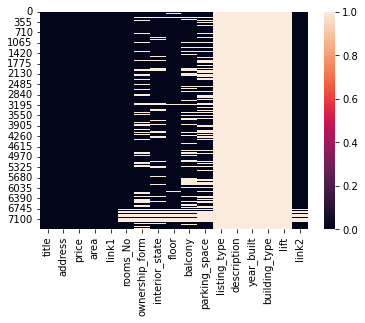

In [55]:
sns.heatmap(df_final.isna())

In [56]:
null_columns = df_final.columns[df_final.isnull().all()]
df_final = df_final.drop(null_columns, axis=1)

In [57]:
df_final.fillna('no data')

,title,address,price,area,link1,rooms_No,ownership_form,interior_state,floor,balcony,parking_space,link2
0,2 pokoje I Metro I Widok na Fort I Bezpośrednio,"ul. Kopalniana, Chrzanów, Bemowo, Warszawa, ma...",870 000 zł,2.00,https://www.otodom.pl/pl/oferta/2-pokoje-i-met...,2,pełna własność,do zamieszkania,2/4,balkon,garaż/miejsce parkingowe,https://www.otodom.pl/pl/oferta/2-pokoje-i-met...
1,3 Pokoje Mokotów / 3 Rooms Mokotów,"ul. Braci Pillatich, Sielce, Mokotów, Warszawa...",695 000 zł,3.00,https://www.otodom.pl/pl/oferta/3-pokoje-mokot...,3,pełna własność,do remontu,2/4,balkon,no data,https://www.otodom.pl/pl/oferta/3-pokoje-mokot...
2,Mieszkania Bezczynnszowe z dużymi ogródkami,"Zerzeń, Wawer, Warszawa, mazowieckie",550 000 zł,50.00,https://www.otodom.pl/pl/oferta/mieszkania-bez...,3,pełna własność,do wykończenia,parter/3,"balkon, ogródek, taras",garaż/miejsce parkingowe,https://www.otodom.pl/pl/oferta/mieszkania-bez...
3,"Białołęka, Krokwi, 2 pokoje, 44 m2","ul. Krokwi, Henryków, Białołęka, Warszawa, maz...",699 000 zł,44.00,https://www.otodom.pl/pl/oferta/bialoleka-krok...,2,pełna własność,do zamieszkania,1/3,balkon,garaż/miejsce parkingowe,https://www.otodom.pl/pl/oferta/bialoleka-krok...
4,"3-pokoje Mieszkanie przy metrze Imielin - 62,0...","Pyry, Ursynów, Warszawa, mazowieckie",870 000 zł,62.08,https://www.otodom.pl/pl/oferta/3-pokoje-miesz...,3,spółdzielcze wł. prawo do lokalu,do zamieszkania,8/10,balkon,no data,https://www.otodom.pl/pl/oferta/3-pokoje-miesz...
...,...,...,...,...,...,...,...,...,...,...,...,...
7435,Dwa pokoje 52m2 Egejska 2019,"ul. Egejska, Stegny, Mokotów, Warszawa, mazowi...",760 000 zł,51.00,https://www.otodom.pl/pl/oferta/dwa-pokoje-52m...,2,pełna własność,do zamieszkania,4/7,taras,no data,https://www.otodom.pl/pl/oferta/dwa-pokoje-52m...
7436,"⭐ 3 pok gotowe - pompa ciepła, panele fotowolt. ⭐","ul. Aluzyjna, Nowodwory, Białołęka, Warszawa, ...",694 000 zł,54.00,https://www.otodom.pl/pl/oferta/3-pok-gotowe-p...,3,no data,no data,3/3,balkon,garaż/miejsce parkingowe,https://www.otodom.pl/pl/oferta/3-pok-gotowe-p...
7437,⭐3 pokoje gotowe - ogród 545m2 + parking za 1 ...,"ul. Aluzyjna, Nowodwory, Białołęka, Warszawa, ...",854 000 zł,59.00,https://www.otodom.pl/pl/oferta/3-pokoje-gotow...,3,no data,no data,parter/3,"balkon, ogródek, taras",garaż/miejsce parkingowe,https://www.otodom.pl/pl/oferta/3-pokoje-gotow...
7438,⭐⭐⭐⭐⭐ 3 pok - EKO instalacje - bardzo niski cz...,"ul. Aluzyjna, Nowodwory, Białołęka, Warszawa, ...",761 000 zł,59.00,https://www.otodom.pl/pl/oferta/3-pok-eko-inst...,3,no data,no data,2/3,balkon,garaż/miejsce parkingowe,https://www.otodom.pl/pl/oferta/3-pok-eko-inst...


In [58]:
def extract_if(string):
    if len(string) == 4:
        return 'empty'
    else:
        return string[0]
    
def insert_zeros(ad_list):
    if len(ad_list) < 5:
        i = 5%len(ad_list)
        return i * ['no info'] + ad_list
    else:
        return ad_list


In [59]:
df_final['address'] = df_final['address'].str.split(",")
df_final['address'] = df_final['address'].apply(insert_zeros)

In [66]:
address = pd.DataFrame(df_final['address'].to_list(), columns=['street', 'nbrhood', 'district', 'city', 'vvdship', 'ad_6', 'ad_7', 'ad_8'])
df_final = df_final.merge(address, left_index=True, right_index=True)

In [42]:
[0] * 2 + ['a', 'a', 'v', 'f', 'f']

[0, 0, 'a', 'a', 'v', 'f', 'f']

In [45]:
df_final['address'].apply(insert_zeros)

0       [ul. Kopalniana,  Chrzanów,  Bemowo,  Warszawa...
1       [ul. Braci Pillatich,  Sielce,  Mokotów,  Wars...
2       [no info, Zerzeń,  Wawer,  Warszawa,  mazowiec...
3       [ul. Krokwi,  Henryków,  Białołęka,  Warszawa,...
4       [no info, Pyry,  Ursynów,  Warszawa,  mazowiec...
                              ...                        
7435    [ul. Egejska,  Stegny,  Mokotów,  Warszawa,  m...
7436    [ul. Aluzyjna,  Nowodwory,  Białołęka,  Warsza...
7437    [ul. Aluzyjna,  Nowodwory,  Białołęka,  Warsza...
7438    [ul. Aluzyjna,  Nowodwory,  Białołęka,  Warsza...
7439    [ul. rtm. Witolda Pileckiego,  Stary Imielin, ...
Name: address, Length: 7440, dtype: object

In [27]:
df_final['city'] = df_final['address'].apply(lambda x: x[-2])
df_final['district'] = df_final['address'].apply(lambda x: x[-3])
df_final['neighbourhood'] = df_final['address'].apply(extr_if)

In [28]:
df_final

,title,address,price,area,link1,rooms_No,ownership_form,interior_state,floor,balcony,parking_space,listing_type,description,year_built,building_type,lift,link2,city,district,neighbourhood
0,2 pokoje I Metro I Widok na Fort I Bezpośrednio,"[ul. Kopalniana, Chrzanów, Bemowo, Warszawa...",870 000 zł,2.00,https://www.otodom.pl/pl/oferta/2-pokoje-i-met...,2,pełna własność,do zamieszkania,2/4,balkon,garaż/miejsce parkingowe,NaN,NaN,NaN,NaN,NaN,https://www.otodom.pl/pl/oferta/2-pokoje-i-met...,Warszawa,Bemowo,ul. Kopalniana Chrzanów
1,3 Pokoje Mokotów / 3 Rooms Mokotów,"[ul. Braci Pillatich, Sielce, Mokotów, Wars...",695 000 zł,3.00,https://www.otodom.pl/pl/oferta/3-pokoje-mokot...,3,pełna własność,do remontu,2/4,balkon,NaN,NaN,NaN,NaN,NaN,NaN,https://www.otodom.pl/pl/oferta/3-pokoje-mokot...,Warszawa,Mokotów,ul. Braci Pillatich Sielce
2,Mieszkania Bezczynnszowe z dużymi ogródkami,"[Zerzeń, Wawer, Warszawa, mazowieckie]",550 000 zł,50.00,https://www.otodom.pl/pl/oferta/mieszkania-bez...,3,pełna własność,do wykończenia,parter/3,"balkon, ogródek, taras",garaż/miejsce parkingowe,NaN,NaN,NaN,NaN,NaN,https://www.otodom.pl/pl/oferta/mieszkania-bez...,Warszawa,Wawer,Zerzeń
3,"Białołęka, Krokwi, 2 pokoje, 44 m2","[ul. Krokwi, Henryków, Białołęka, Warszawa,...",699 000 zł,44.00,https://www.otodom.pl/pl/oferta/bialoleka-krok...,2,pełna własność,do zamieszkania,1/3,balkon,garaż/miejsce parkingowe,NaN,NaN,NaN,NaN,NaN,https://www.otodom.pl/pl/oferta/bialoleka-krok...,Warszawa,Białołęka,ul. Krokwi Henryków
4,"3-pokoje Mieszkanie przy metrze Imielin - 62,0...","[Pyry, Ursynów, Warszawa, mazowieckie]",870 000 zł,62.08,https://www.otodom.pl/pl/oferta/3-pokoje-miesz...,3,spółdzielcze wł. prawo do lokalu,do zamieszkania,8/10,balkon,NaN,NaN,NaN,NaN,NaN,NaN,https://www.otodom.pl/pl/oferta/3-pokoje-miesz...,Warszawa,Ursynów,Pyry
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7435,Dwa pokoje 52m2 Egejska 2019,"[ul. Egejska, Stegny, Mokotów, Warszawa, m...",760 000 zł,51.00,https://www.otodom.pl/pl/oferta/dwa-pokoje-52m...,2,pełna własność,do zamieszkania,4/7,taras,NaN,NaN,NaN,NaN,NaN,NaN,https://www.otodom.pl/pl/oferta/dwa-pokoje-52m...,Warszawa,Mokotów,ul. Egejska Stegny
7436,"⭐ 3 pok gotowe - pompa ciepła, panele fotowolt. ⭐","[ul. Aluzyjna, Nowodwory, Białołęka, Warsza...",694 000 zł,54.00,https://www.otodom.pl/pl/oferta/3-pok-gotowe-p...,3,NaN,NaN,3/3,balkon,garaż/miejsce parkingowe,NaN,NaN,NaN,NaN,NaN,https://www.otodom.pl/pl/oferta/3-pok-gotowe-p...,Warszawa,Białołęka,ul. Aluzyjna Nowodwory
7437,⭐3 pokoje gotowe - ogród 545m2 + parking za 1 ...,"[ul. Aluzyjna, Nowodwory, Białołęka, Warsza...",854 000 zł,59.00,https://www.otodom.pl/pl/oferta/3-pokoje-gotow...,3,NaN,NaN,parter/3,"balkon, ogródek, taras",garaż/miejsce parkingowe,NaN,NaN,NaN,NaN,NaN,https://www.otodom.pl/pl/oferta/3-pokoje-gotow...,Warszawa,Białołęka,ul. Aluzyjna Nowodwory
7438,⭐⭐⭐⭐⭐ 3 pok - EKO instalacje - bardzo niski cz...,"[ul. Aluzyjna, Nowodwory, Białołęka, Warsza...",761 000 zł,59.00,https://www.otodom.pl/pl/oferta/3-pok-eko-inst...,3,NaN,NaN,2/3,balkon,garaż/miejsce parkingowe,NaN,NaN,NaN,NaN,NaN,https://www.otodom.pl/pl/oferta/3-pok-eko-inst...,Warszawa,Białołęka,ul. Aluzyjna Nowodwory


In [71]:
df_final['price'].str.findall('\s')

0       [ ,  ]
1       [ ,  ]
2       [ ,  ]
3       [ ,  ]
4       [ ,  ]
         ...  
7435    [ ,  ]
7436    [ ,  ]
7437    [ ,  ]
7438    [ ,  ]
7439    [ ,  ]
Name: price, Length: 7440, dtype: object

In [85]:
def convert_to_integer(s):
    if isinstance(s, str):
        # Remove non-numeric characters
        numeric_str = ''.join(filter(str.isdigit, s))
        # Check for empty strings
        if numeric_str:
            return int(numeric_str)
    # If the value is not a string, return it as is (or handle it differently)
    return s

In [76]:
df_final['price'] = df_final['price'].apply(convert_to_integer)

In [80]:
df_final.head()

,title,address,price,area,link1,rooms_No,ownership_form,interior_state,floor,balcony,parking_space,link2,street,nbrhood,district,city,vvdship,ad_6,ad_7,ad_8
0,2 pokoje I Metro I Widok na Fort I Bezpośrednio,"[ul. Kopalniana, Chrzanów, Bemowo, Warszawa...",870000.0,2.00,https://www.otodom.pl/pl/oferta/2-pokoje-i-met...,2,pełna własność,do zamieszkania,2/4,balkon,garaż/miejsce parkingowe,https://www.otodom.pl/pl/oferta/2-pokoje-i-met...,ul. Kopalniana,Chrzanów,Bemowo,Warszawa,mazowieckie,None,None,None
1,3 Pokoje Mokotów / 3 Rooms Mokotów,"[ul. Braci Pillatich, Sielce, Mokotów, Wars...",695000.0,3.00,https://www.otodom.pl/pl/oferta/3-pokoje-mokot...,3,pełna własność,do remontu,2/4,balkon,NaN,https://www.otodom.pl/pl/oferta/3-pokoje-mokot...,ul. Braci Pillatich,Sielce,Mokotów,Warszawa,mazowieckie,None,None,None
2,Mieszkania Bezczynnszowe z dużymi ogródkami,"[no info, Zerzeń, Wawer, Warszawa, mazowiec...",550000.0,50.00,https://www.otodom.pl/pl/oferta/mieszkania-bez...,3,pełna własność,do wykończenia,parter/3,"balkon, ogródek, taras",garaż/miejsce parkingowe,https://www.otodom.pl/pl/oferta/mieszkania-bez...,no info,Zerzeń,Wawer,Warszawa,mazowieckie,None,None,None
3,"Białołęka, Krokwi, 2 pokoje, 44 m2","[ul. Krokwi, Henryków, Białołęka, Warszawa,...",699000.0,44.00,https://www.otodom.pl/pl/oferta/bialoleka-krok...,2,pełna własność,do zamieszkania,1/3,balkon,garaż/miejsce parkingowe,https://www.otodom.pl/pl/oferta/bialoleka-krok...,ul. Krokwi,Henryków,Białołęka,Warszawa,mazowieckie,None,None,None
4,"3-pokoje Mieszkanie przy metrze Imielin - 62,0...","[no info, Pyry, Ursynów, Warszawa, mazowiec...",870000.0,62.08,https://www.otodom.pl/pl/oferta/3-pokoje-miesz...,3,spółdzielcze wł. prawo do lokalu,do zamieszkania,8/10,balkon,NaN,https://www.otodom.pl/pl/oferta/3-pokoje-miesz...,no info,Pyry,Ursynów,Warszawa,mazowieckie,None,None,None


In [86]:
df_final['rooms_No'] = df_final['rooms_No'].apply(convert_to_integer)

0       2.0
1       3.0
2       3.0
3       2.0
4       3.0
       ... 
7435    2.0
7436    3.0
7437    3.0
7438    3.0
7439    2.0
Name: rooms_No, Length: 7440, dtype: float64

In [94]:
df_final['floor'] = df_final['floor'].str.replace('parter', '0').str.split('/')

In [98]:
df_final['floor'].value_counts()

TypeError: unhashable type: 'list'

Exception ignored in: 'pandas._libs.index.IndexEngine._call_map_locations'
Traceback (most recent call last):
  File "pandas/_libs/hashtable_class_helper.pxi", line 5231, in pandas._libs.hashtable.PyObjectHashTable.map_locations
TypeError: unhashable type: 'list'


[1, 2]            314
[2, 3]            294
[3, 3]            286
[4, 4]            275
[3, 4]            274
                 ... 
[7, 6]              1
[suterena, 1]       1
[0, 20]             1
[10]                1
[poddasze, 52]      1
Name: floor, Length: 179, dtype: int64